In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

import warnings

warnings.filterwarnings("ignore")

In [71]:
# Definimos una función para asignar las categorías
def asignar_categoria(media):
    if media < 10:
        return "suspenso"
    else:
        return "aprobado"

# Lectura del dataset y Primeros ajustes

Leemos los datos del dataset. A continuacion eliminamos los atributos 'school' y 'paid' ya que 'paid' es un atributo repetido en nuestro dataset y 'shool' es un atributo que unicamente tiene 2 nombres de institutos que tras comprobar las salidas de los modelos y los datos de estos hemos llegado a la conclusion de que sesgaba mucho los modelos, ya que era practicamente el unico atributo que comprobaba.

A continuacion añadiremos las columnas 'Media_G1_G2' y 'Calificacion', que emplearemos para 2 objetivos distintos. Al basar nuestro modelo en comprobar si los alumnos tendran problemas para pasar el curso debido a los problemas de alcoholismo intentamos averiguar su nota del primer semestre 'G1' y del segundo 'G2'. Pero para una mayor generalizacion si pasará el curso o no hemos optado por calcular la nota media de los semestres y emplear dicho atributo como target para nuestra prediccion.
Por otro lado, el atributo 'Calificacion' es una etiqueta sobre si el alumno ha aprobado o no comprobando la media del curso calculada previamente. Este será nuestro target para los modelos de clasificación.

In [72]:
# Lee el archivo CSV
df = pd.read_csv('student.csv')

# Eliminamos las columnas 'school' y 'paid'
df = df.drop(['school', 'paid'], axis=1)

# Calculamos la media de las columnas G1 y G2
df['Media_G1_G2'] = df[['G1', 'G2']].mean(axis=1)

# Aplicamos la función a la nueva columna para crear la columna de categorías
df['Calificacion'] = df['Media_G1_G2'].apply(asignar_categoria)
    
# Con esta función seleccionamos los atributos categóricos y los transformamos a codificación one-hot
categorical_columns = df.select_dtypes(include=['object']).columns
for i in categorical_columns:
    if len(df[i].unique()) == 2:
        # Si solo hay dos categorías, usar LabelEncoder
        le = LabelEncoder()
        df[i] = le.fit_transform(df[i])
    else:
        df_dummies = pd.get_dummies(df[i], prefix=i)
        df = pd.concat([df.drop(i, axis=1), df_dummies],axis=1)
df['Media_G1_G2'] = df['Media_G1_G2'].astype(int)

Test_names = df.columns.tolist()

# Eliminamos las columnas especificadas de la lista
for column in ['G1', 'G2', 'Media_G1_G2', 'Calificacion']:
    Test_names.remove(column)

### Particionamiento del dataset en Train-Validation-Test
Particionamos los datos en train,validacion y test por cada atributo target que tenemos, en este caso son 3 'G1','G2' y 'Media_G1_G2'.

In [73]:
# Hacemos un particionamiento estándar, 60% para train y 40% para test
train_data, temp_data = train_test_split(df, test_size=0.4, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Sacamos los atributos target
y_train_G1 = train_data['G1']
y_train_G2 = train_data['G2']
y_train_media = train_data['Media_G1_G2']


# Definimos X con el resto de atributos que no son los targets
X_train = train_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)

# Definimos los conjuntos de Test
y_test_G1 = test_data['G1']
y_test_G2 = test_data['G2']
y_test_media = test_data['Media_G1_G2']

# Sacamos los atributos de validacion
y_test_G1 = val_data['G1']
y_test_G2 = val_data['G2']
y_test_media = val_data['Media_G1_G2']

# Definimos X con el resto de atributos que no son los targets
X_test = test_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)
X_val = val_data.drop(['G1', 'G2','Media_G1_G2','Calificacion'], axis=1)


y_train_calificacion = train_data['Calificacion']
y_test_calificacion = test_data['Calificacion']
y_val_calificacion = val_data['Calificacion']

### Estandarizacion de datos

Estandarizamos los datos que usamos en los modelos para funcionamiento mas optimo.

In [74]:
# Creamos el estandarizador
scaler = StandardScaler()

# Ajustamos el estandarizador con los datos de entrenamiento y luego transformamos los datos de entrenamiento
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Regresion Lineal

Al tener como target un atributo numerico nos parecía interesante probar un modelo de prediccion.

In [75]:
# Aplicamos el modelo de regresión lineal
modelo_lineal_G1 = LinearRegression()
modelo_lineal_G2 = LinearRegression()
modelo_lineal_media = LinearRegression()

# Entrenamos el modelo
modelo_lineal_G1.fit(X_train, y_train_G1)
modelo_lineal_G2.fit(X_train, y_train_G2)
modelo_lineal_media.fit(X_train, y_train_media)

# Calculamos la salida del modelo
y_pred_G1 = modelo_lineal_G1.predict(X_test)
y_pred_G2 = modelo_lineal_G2.predict(X_test)
y_pred_media = modelo_lineal_media.predict(X_test)

# Medimos el error cuadrático medio del modelo
mse_G1 = mean_squared_error(y_test_G1, y_pred_G1)
mse_G2 = mean_squared_error(y_test_G2, y_pred_G2)
mse_media = mean_squared_error(y_test_media, y_pred_media)

# Redondeamos las predicciones al entero más cercano
y_pred_G1_rounded = np.round(y_pred_G1)
y_pred_G2_rounded = np.round(y_pred_G2)
y_pred_media_rounded = np.round(y_pred_media)

# Calculamos la precisión del modelo
accuracy_G1 = accuracy_score(y_test_G1, y_pred_G1_rounded)
accuracy_G2 = accuracy_score(y_test_G2, y_pred_G2_rounded)
accuracy_media = accuracy_score(y_test_media, y_pred_media_rounded)

print("Precision para G1 = ", round(accuracy_G1*100,2), "%")
print("Precision para G2 = ", round(accuracy_G2*100,2), "%")
print("Precision para Media = ", round(accuracy_media*100,2), "%")

# Generamos las predicciones del modelo para los datos de entrenamiento
y_train_pred_G1 = modelo_lineal_G1.predict(X_train)
y_train_pred_G2 = modelo_lineal_G2.predict(X_train)
y_train_pred_media = modelo_lineal_media.predict(X_train)

Precision para G1 =  10.77 %
Precision para G2 =  9.23 %
Precision para Media =  11.54 %


Como vemos los porcentajes de accuracy son muy bajos, por lo que entendemos que predecir la nota exacta no es viable por lo meno mediante esta técnica. A continuación probaremos con un modelo polinómico para comprobar si de esta manera conseguimos un mejor resultado.

# Regresion Lineal Polinomica (grado: 3)

In [76]:
# Creamos una instancia de LinearRegression
model_G1 = LinearRegression()
model_G2 = LinearRegression()
model_media = LinearRegression()

degree = 3

# Creamos una instancia de PolynomialFeatures para transformar nuestros datos a un espacio polinomial
poly = PolynomialFeatures(degree=degree)

# Transformamos nuestros datos de entrenamiento y de prueba
X_train_poly_G1 = poly.fit_transform(X_train)
X_test_poly_G1 = poly.transform(X_test)

X_train_poly_G2 = poly.fit_transform(X_train)
X_test_poly_G2 = poly.transform(X_test)

X_train_poly_media = poly.fit_transform(X_train)
X_test_poly_media = poly.transform(X_test)

# Entrenamos el modelo
model_G1.fit(X_train_poly_G1, y_train_G1)
model_G2.fit(X_train_poly_G2, y_train_G2)
model_media.fit(X_train_poly_media, y_train_media)

# Hacemos predicciones
y_pred_G1 = model_G1.predict(X_test_poly_G1)
y_pred_G2 = model_G2.predict(X_test_poly_G2)
y_pred_media = model_media.predict(X_test_poly_media)

# Calculamos la precisión del modelo
precision_G1 = accuracy_score(y_test_G1, np.round(y_pred_G1))
precision_G2 = accuracy_score(y_test_G2, np.round(y_pred_G2))
precision_media = accuracy_score(y_test_media, np.round(y_pred_media))

print(f"Grado del polinomio: {degree}")
print("Precision para G1 = ", round(precision_G1*100,2), "%")
print("Precision para G2 = ", round(precision_G2*100,2), "%")
print("Precision para Media = ", round(precision_media*100,2), "%")
print("\n")

Grado del polinomio: 3
Precision para G1 =  8.46 %
Precision para G2 =  12.31 %
Precision para Media =  10.77 %




Como podemos comprobar el accuracy ha subido de forma general al aplicar las polinómicas en el modelo, pero el resultado sigue siedo tan bajo que comprenderemos que esta taréa no nos dará buenos resultados con estas técnicas, por tanto las descartarémos.

### Graficamos los datos que hemos calculado

Veremos de manera gráfica los datos comparados con las predicciones y como nuestro modelo se ajusta a estos datos.

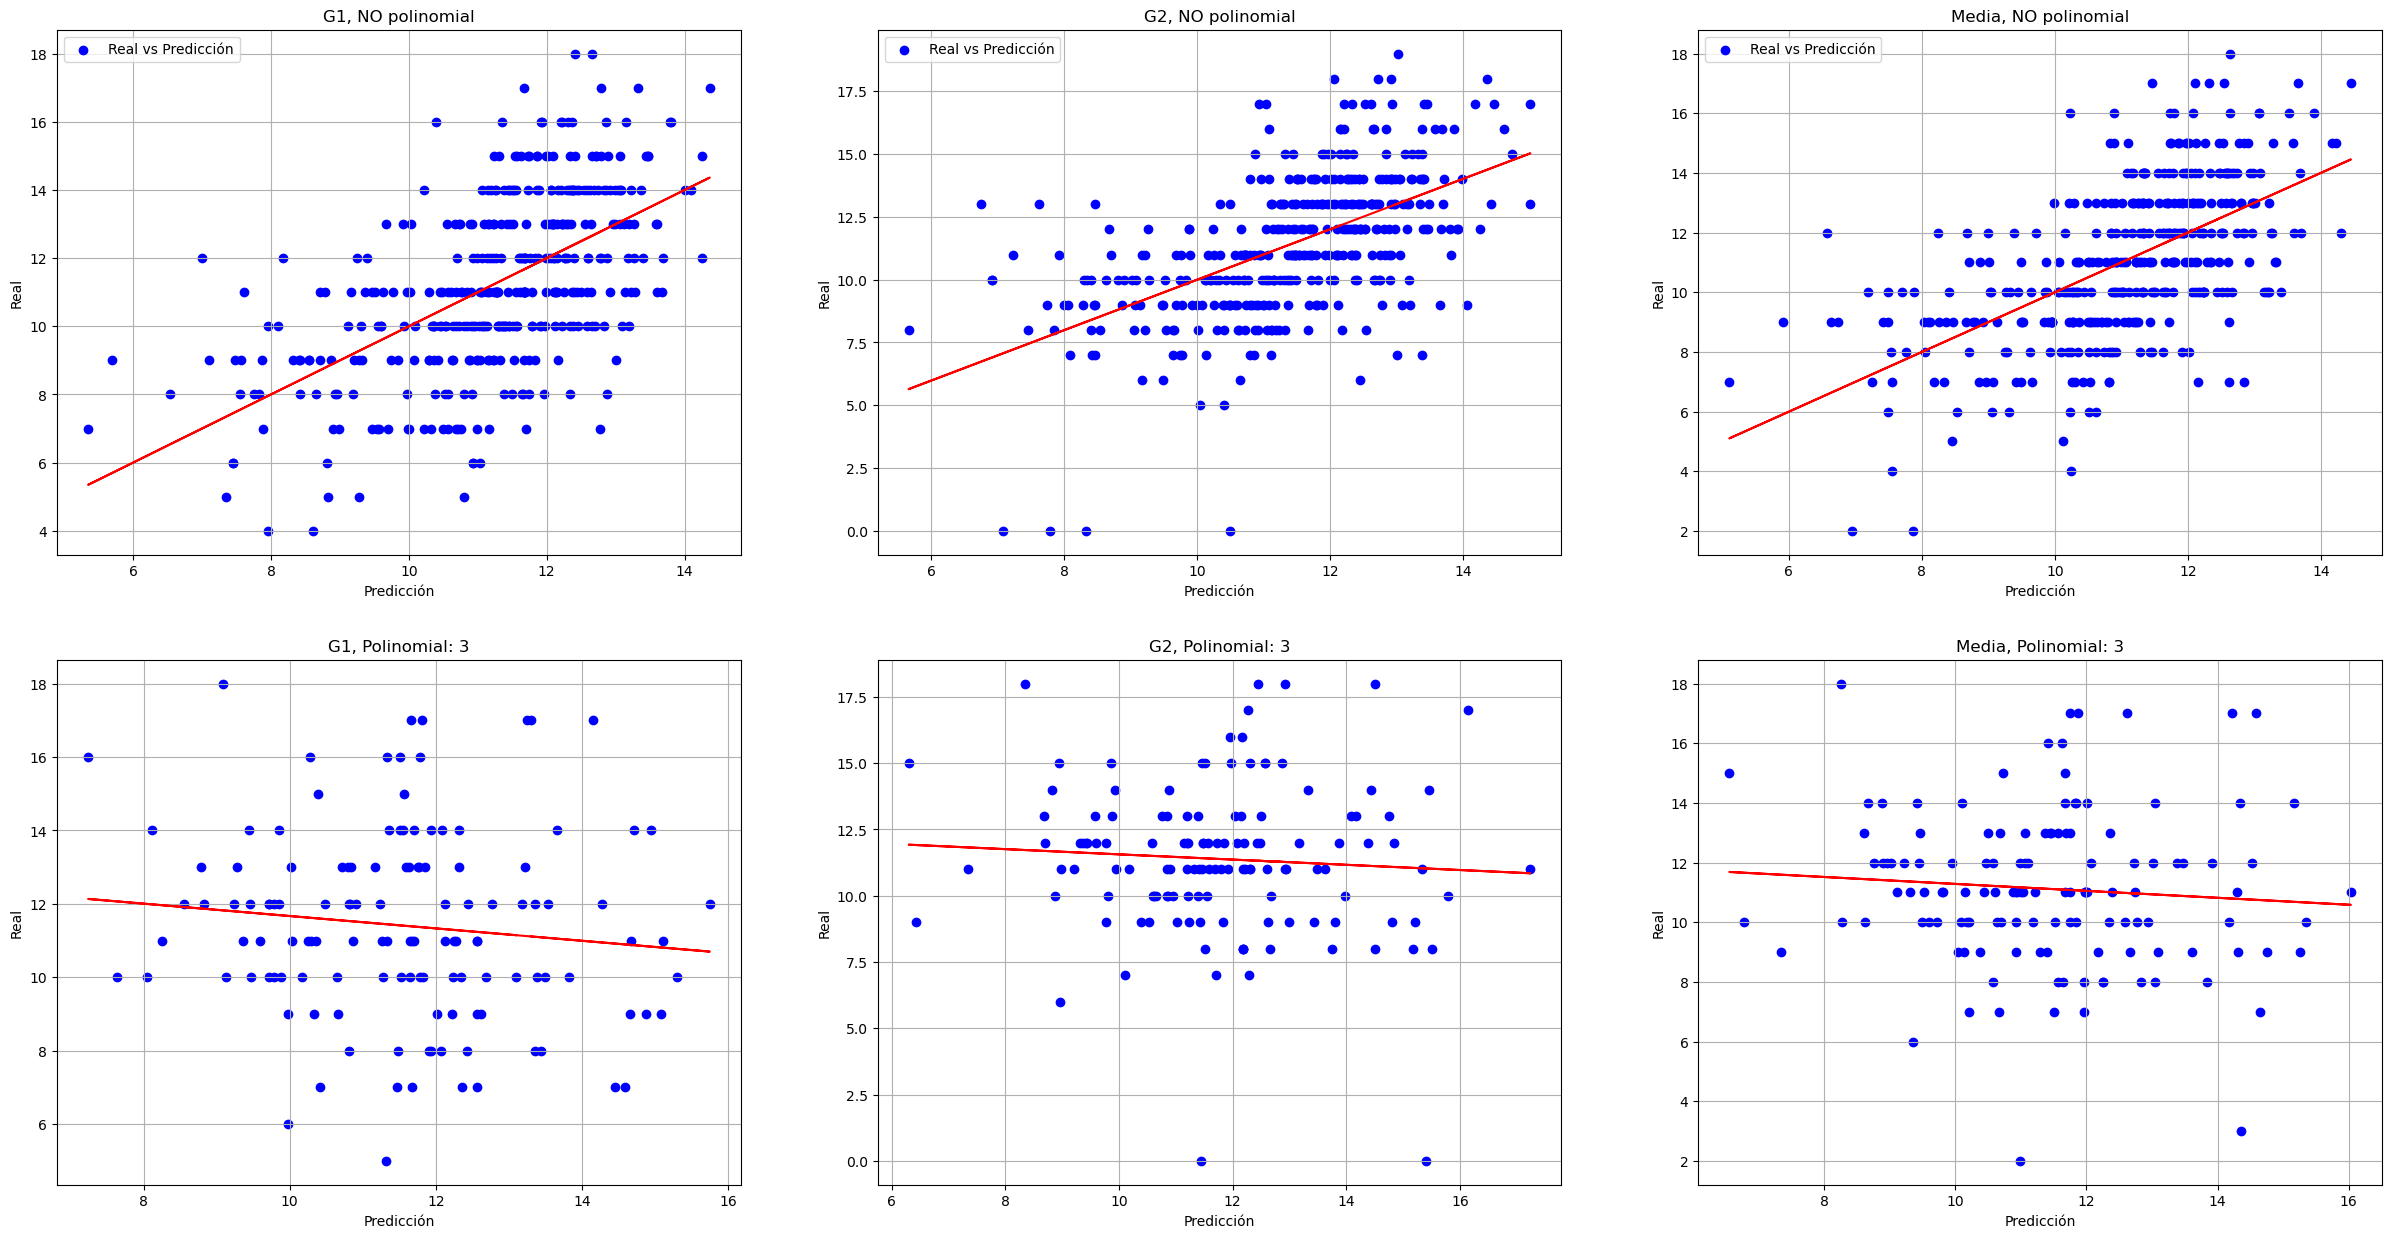

In [77]:
# Creamos una figura y un conjunto de subtramas
fig, ax = plt.subplots(2, 3, figsize=(30, 15))

# Graficamos los datos reales y las predicciones del modelo para G1
ax[0][0].scatter(y_train_pred_G1, y_train_G1, color='blue', label='Real vs Predicción')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_train_pred_G1, y_train_G1, 1)
ax[0][0].plot(y_train_pred_G1, m*y_train_pred_G1 + b, color='red')

ax[0][0].set_title('G1, NO polinomial')
ax[0][0].set_xlabel('Predicción')
ax[0][0].set_ylabel('Real')
ax[0][0].grid(True)
ax[0][0].legend()

# Graficamos los datos reales y las predicciones del modelo para G2
ax[0][1].scatter(y_train_pred_G2, y_train_G2, color='blue', label='Real vs Predicción')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_train_pred_G2, y_train_G2, 1)
ax[0][1].plot(y_train_pred_G2, m*y_train_pred_G2 + b, color='red')

ax[0][1].set_title('G2, NO polinomial')
ax[0][1].set_xlabel('Predicción')
ax[0][1].set_ylabel('Real')
ax[0][1].grid(True)
ax[0][1].legend()

# Graficamos los datos reales y las predicciones del modelo para Media
ax[0][2].scatter(y_train_pred_media, y_train_media, color='blue', label='Real vs Predicción')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_train_pred_media, y_train_media, 1)
ax[0][2].plot(y_train_pred_media, m*y_train_pred_media + b, color='red')

ax[0][2].set_title('Media, NO polinomial')
ax[0][2].set_xlabel('Predicción')
ax[0][2].set_ylabel('Real')
ax[0][2].grid(True)
ax[0][2].legend()

# Graficamos los datos reales y las predicciones del modelo para G1
ax[1][0].scatter(y_pred_G1, y_test_G1, color='blue')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_pred_G1, y_test_G1, 1)
ax[1][0].plot(y_pred_G1, m*y_pred_G1 + b, color='red')

ax[1][0].set_title(f"G1, Polinomial: {degree}")
ax[1][0].set_xlabel('Predicción')
ax[1][0].set_ylabel('Real')
ax[1][0].grid(True)

# Graficamos los datos reales y las predicciones del modelo para G2
ax[1][1].scatter(y_pred_G2, y_test_G2, color='blue')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_pred_G2, y_test_G2, 1)
ax[1][1].plot(y_pred_G2, m*y_pred_G2 + b, color='red')

ax[1][1].set_title(f"G2, Polinomial: {degree}")
ax[1][1].set_xlabel('Predicción')
ax[1][1].set_ylabel('Real')
ax[1][1].grid(True)

# Graficamos los datos reales y las predicciones del modelo para G2
ax[1][2].scatter(y_pred_media, y_test_media, color='blue')

# Añadimos la línea de regresión lineal
m, b = np.polyfit(y_pred_media, y_test_media, 1)
ax[1][2].plot(y_pred_media, m*y_pred_media + b, color='red')

ax[1][2].set_title(f"Media, Polinomial: {degree}")
ax[1][2].set_xlabel('Predicción')
ax[1][2].set_ylabel('Real')
ax[1][2].grid(True)

# Mostramos la figura
plt.show()

### Conclusiones
Como podemos comprobar se forma una nube de puntos que nos indica que el accuracy de este modelo será muy bajo debido a la diversidad de los datos.

# Regresion Logística

Una vez descartado los modelos de predicción probaremos el modelo mas simple que hemos estudiado de clasificacion, emplearemos como target el atributo que hemos creado para etiquetar los ejemplos 'Calificacion'.

Probaremos tambien distintas maneras de ejecutar este modelo que hemos investigado para encontrar la mejor comfiguración.

In [78]:
# Aplicamos el modelo de regresion logistica
modelo_logistico_calificacion = LogisticRegression()


#Definimos los parametros posibles de nuestro modelo
param_grid = {
    'C': [0.1, 0.5, 1, 10],              
    'solver': ['newton-cg', 'lbfgs', 'liblinear'], 
    'multi_class': ['ovr', 'multinomial'],
    'penalty': ['l1', 'l2']
}

grid_search_log = GridSearchCV(modelo_logistico_calificacion, param_grid, cv=5, scoring='accuracy')

# Ejecutar la búsqueda en el conjunto de datos
grid_search_log.fit(X_train, y_train_calificacion)

# Obtener el mejor modelo y sus parámetros
best_model_log = grid_search_log.best_estimator_
best_params_log = grid_search_log.best_params_


print("Mejores parámetros:", best_params_log)

#Precision Validacion
y_pred_val = best_model_log.predict(X_val)
precision_calificacion_val = accuracy_score(y_val_calificacion, y_pred_val)
print("Precision validacion: ", 100 * precision_calificacion_val, "%")

#Precision Test
y_pred_test = best_model_log.predict(X_test)
precision_calificacion_test = accuracy_score(y_test_calificacion, y_pred_test)
print("Precision test: ", 100 * precision_calificacion_test, "%")

Mejores parámetros: {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
Precision validacion:  76.92307692307693 %
Precision test:  79.23076923076923 %


### Estudio de atributos mas significativos

In [79]:
# Imprimir los coeficientes del modelo
coef_df = pd.DataFrame(best_model_log.coef_[0], index=Test_names, columns=["Coeficiente"])

# Calcular la importancia de las características
importance = np.abs(best_model_log.coef_[0])

# Crear un DataFrame para visualizar las características y su importancia
importance_df = pd.DataFrame(importance, index=Test_names, columns=["Pesos"])

# Ordenar el DataFrame por importancia
importance_df = importance_df.sort_values(by='Pesos', ascending=False)

# Ensembles Adaboost

In [80]:
from sklearn.model_selection import cross_val_score

mejor_acc_calificacion = 0
precision = []

clasificadores = np.arange(1, 29)

for i in clasificadores:
    # Definimos el clasificador base
    clasificador_base = DecisionTreeClassifier(criterion='entropy', max_depth=1)

    # Definimos el modelo
    adaboost = AdaBoostClassifier(base_estimator=clasificador_base, n_estimators=i, random_state=12)
    
    # Realizamos la validación cruzada con k=5 en el conjunto de entrenamiento
    scores = cross_val_score(adaboost, X_train, y_train_calificacion, cv=5, scoring='accuracy')
    
    # Calculamos la precisión promedio en la validación cruzada
    accuracy_val_calificacion = round(100 * np.mean(scores), 2)

    # Añadimos las precisiones a su correspondiente lista para dibujarlas en las gráficas
    precision.append(accuracy_val_calificacion)

    # Comprobamos cual es el mejor número de clasificadores para obtener la mayor precisión en la validación cruzada
    if accuracy_val_calificacion >= mejor_acc_calificacion:
        mejor_acc_calificacion = accuracy_val_calificacion
        mejor_num_clasificadores_calificacion = i

# Después de encontrar el mejor número de clasificadores en la validación cruzada, evaluar en el conjunto de prueba
adaboost_best = AdaBoostClassifier(base_estimator=clasificador_base, n_estimators=mejor_num_clasificadores_calificacion, random_state=12)
adaboost_best.fit(X_train, y_train_calificacion)
accuracy_test_calificacion = round(100 * adaboost_best.score(X_test, y_test_calificacion), 2)

print("El mejor número de clasificadores es:", mejor_num_clasificadores_calificacion, "con una precisión promedio en la validación cruzada del:", mejor_acc_calificacion, "%")
print("Precisión en el conjunto de prueba:", accuracy_test_calificacion, "%")

El mejor número de clasificadores es: 3 con una precisión promedio en la validación cruzada del: 78.41 %
Precisión en el conjunto de prueba: 80.0 %


### Estudio de atributos mas significativos

In [81]:

# Obtener la importancia de las características
adaboost_importances = adaboost_best.feature_importances_

# Crear un DataFrame para visualizar las características y su importancia
df_importances = pd.DataFrame(adaboost_importances, index=Test_names, columns=["Importancia"])

# Ordenar el DataFrame por importancia
df_importances = df_importances.sort_values(by='Importancia', ascending=False)

# Adaboost con GridSearch

In [82]:
#Defininos el clasificadores base
clasificador_base = DecisionTreeClassifier(criterion='entropy', max_depth=1)

param_grid = {
    'n_estimators': list(range(1, 30))
}

adaboost = AdaBoostClassifier(base_estimator=clasificador_base)
grid_search_adaboost = GridSearchCV(adaboost, param_grid, cv=5, scoring='accuracy')

# Ejecutar la búsqueda en el conjunto de datos
grid_search_adaboost.fit(X_train, y_train_calificacion)

# Obtener el mejor modelo y sus parámetros
best_model_adaboost = grid_search_adaboost.best_estimator_
best_params_adaboost = grid_search_adaboost.best_params_

print("Mejores parámetros:", best_params_adaboost)


#Precision Validacion
y_pred_val = best_model_adaboost.predict(X_val)
precision_calificacion_val = accuracy_score(y_val_calificacion, y_pred_val)
print("Precision validacion: ", 100 * precision_calificacion_val, "%")

#Precision Test
y_pred_test = best_model_adaboost.predict(X_test)
precision_calificacion_test = accuracy_score(y_test_calificacion, y_pred_test)
print("Precision test: ", 100 * precision_calificacion_test, "%\n")

Mejores parámetros: {'n_estimators': 3}
Precision validacion:  77.6923076923077 %
Precision test:  80.0 %



### Estudio de atributos mas significativos

In [95]:
# Obtener la importancia de las características
adaboostGridsearch_features = best_model_adaboost.feature_importances_

# Crear un DataFrame para visualizar las características y su importancia
df_importances = pd.DataFrame(adaboostGridsearch_features, index=Test_names, columns=["Importancia"])

# Ordenar el DataFrame por importancia
df_importances = df_importances.sort_values(by='Importancia', ascending=False)

print(df_importances)


[0.         0.         0.         0.         0.         0.
 0.33333333 0.         0.         0.         0.         0.
 0.         0.33333333 0.         0.         0.         0.
 0.         0.33333333 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
                   Importancia
Dalc                  0.333333
Fedu                  0.333333
higher                0.333333
sex                   0.000000
Fjob_other            0.000000
Mjob_health           0.000000
Mjob_other            0.000000
Mjob_services         0.000000
Mjob_teacher          0.000000
Fjob_at_home          0.000000
Fjob_health           0.000000
Fjob_services         0.000000
absences              0.000000
Fjob_teacher          0.000000
reason_course         0.000000
reason_home           0.000000
reason_other          0.000000
reason_reputation     0.000000
guardian_fa

### Graficamos la precision de Adaboost

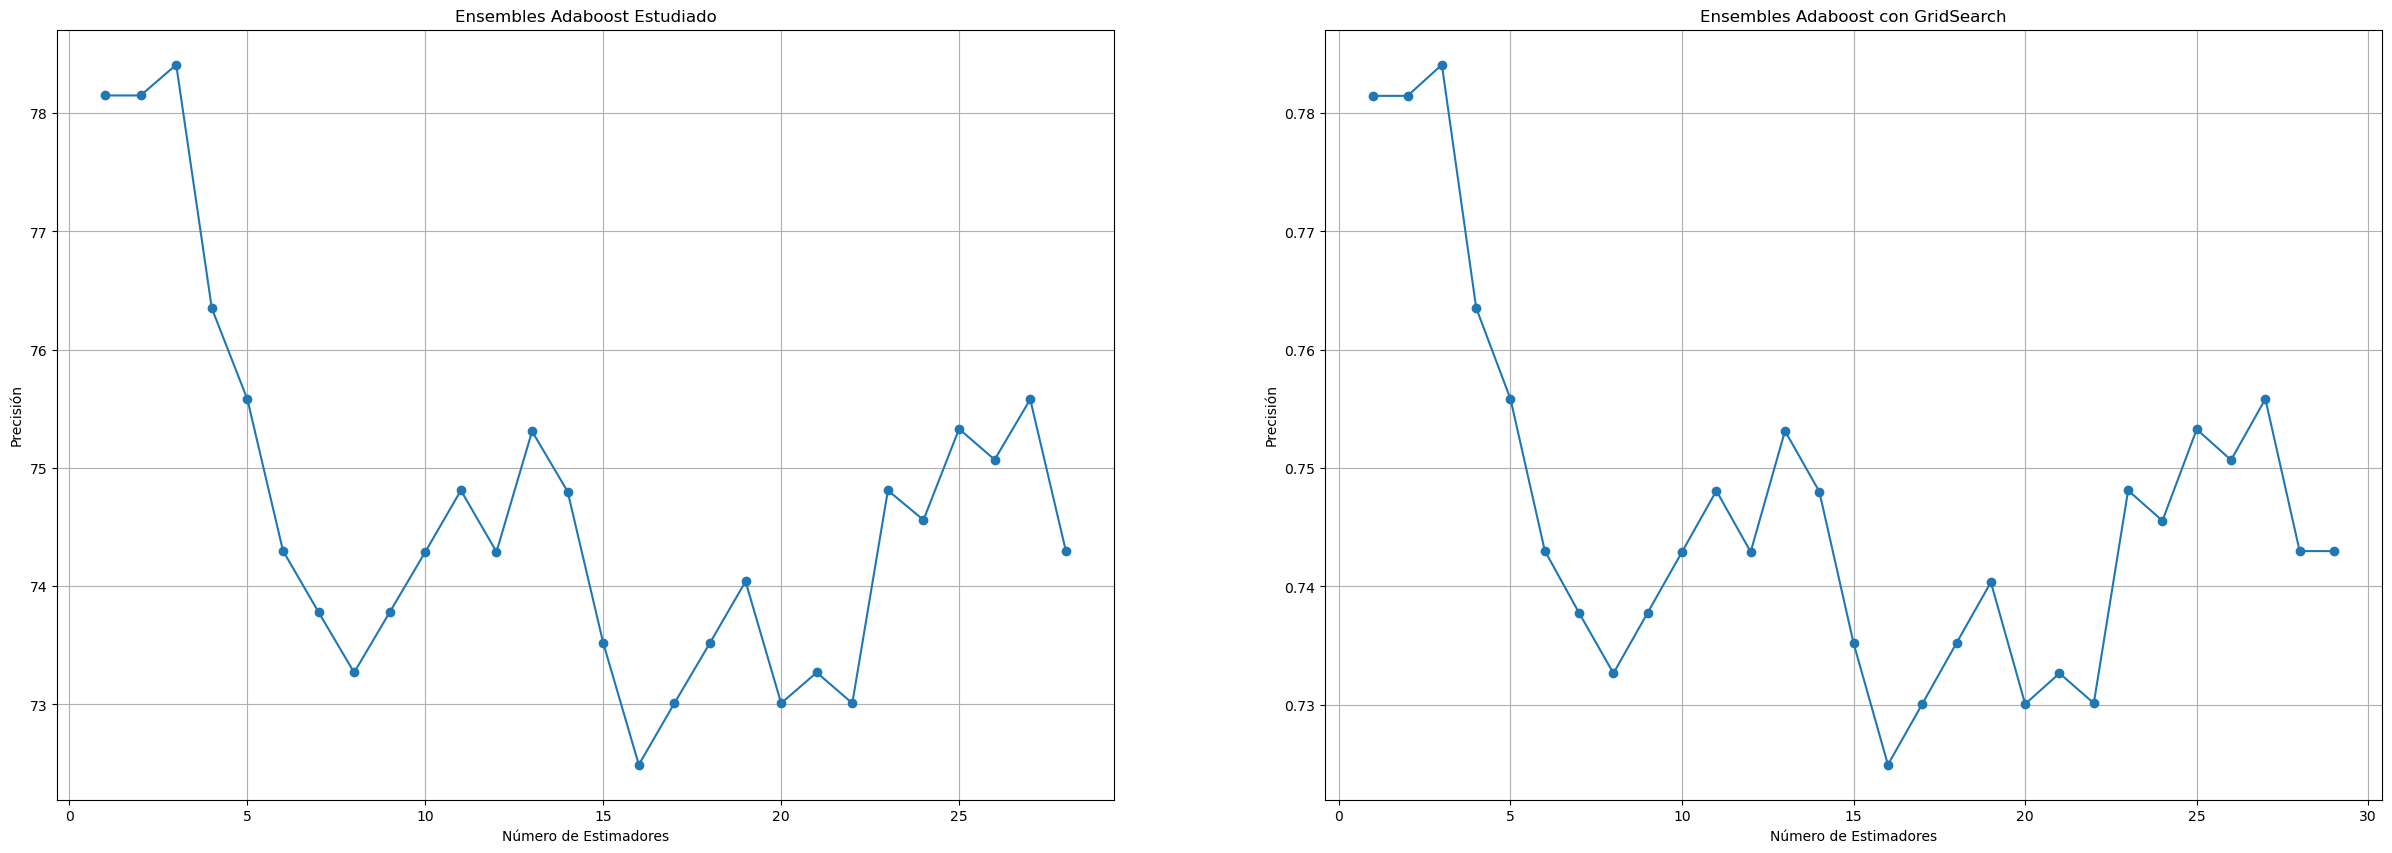

In [86]:
# Creamos una figura y un conjunto de subtramas
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

ax[0].plot(clasificadores, precision, marker='o')
ax[0].set_title('Ensembles Adaboost Estudiado')
ax[0].set_xlabel('Número de Estimadores')
ax[0].set_ylabel('Precisión')
ax[0].grid(True)

# Obtener los resultados de la validación cruzada
cv_results = grid_search_adaboost.cv_results_


# Obtener las puntuaciones de prueba media para cada número de estimadores
mean_test_scores = cv_results['mean_test_score']

# Crear una lista con el número de estimadores
n_estimators = list(range(1, 30))

# Graficar la precisión en función del número de estimadores
ax[1].plot(n_estimators, mean_test_scores, marker='o')

# Configurar el título y las etiquetas de los ejes
ax[1].set_title('Ensembles Adaboost con GridSearch')
ax[1].set_xlabel('Número de Estimadores')
ax[1].set_ylabel('Precisión')

# Mostrar la gráfica
ax[1].grid(True)
plt.show()






### Comparacion de PESOS entre modelos

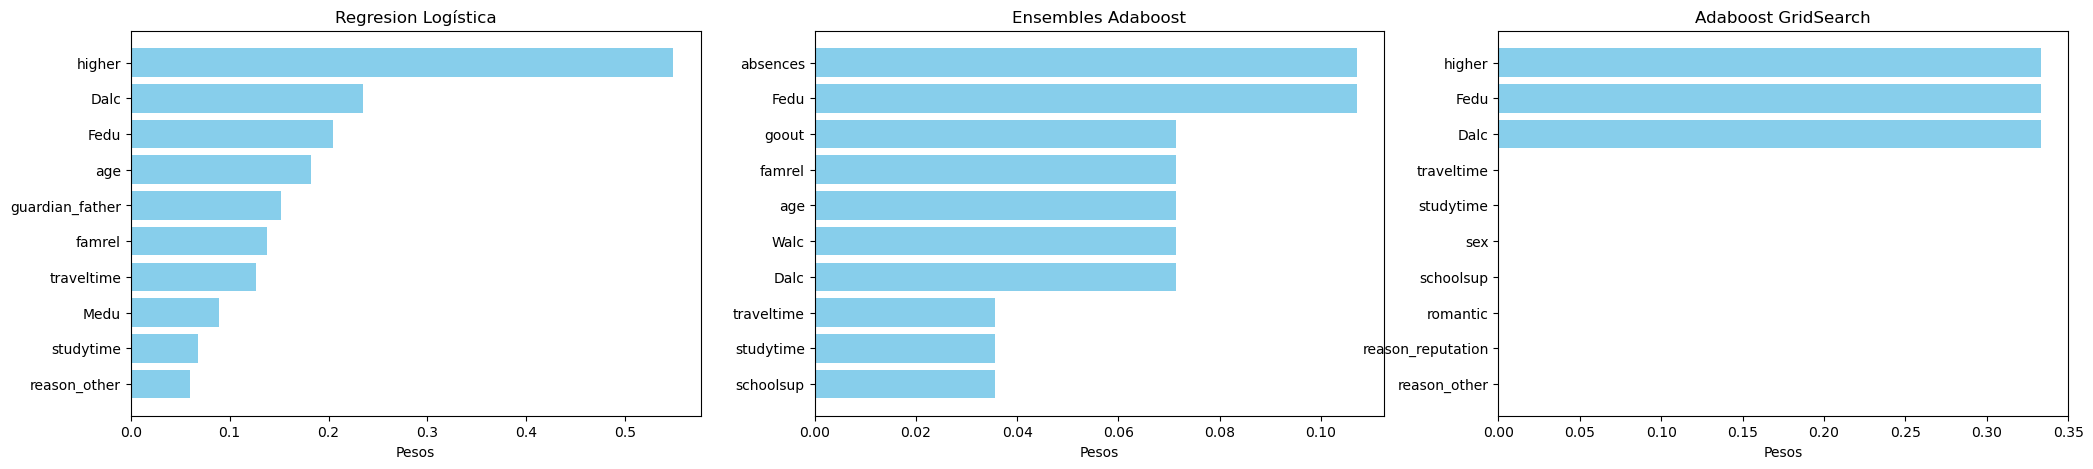

In [ ]:
# Crear una figura y un conjunto de ejes
fig, axs = plt.subplots(1,3, figsize=(25, 5))

#REGRESION LOGÍSTICA

# Calcular la importancia de las características
importance = np.abs(best_model_log.coef_[0])

# Ordenar las características por importancia
indices = np.argsort(importance)

# Crear una lista de tuplas (importancia, característica)
importances_features = [(importance[i], Test_names[i]) for i in indices]

# Ordenar la lista de tuplas por importancia
importances_features.sort(reverse=True)

# Obtener las 10 características más importantes
top_features = importances_features[:10]

# Separar las importancias y los nombres de las características
importances = [importance for importance, _ in top_features]
features = [feature for _, feature in top_features]

# Crear un gráfico de barras horizontal
axs[0].barh(features, importances, color='skyblue')

# Invertir el eje y para que las características más importantes aparezcan en la parte superior
axs[0].invert_yaxis()

# Configurar el título y las etiquetas de los ejes
axs[0].set_title('Regresion Logística')
axs[0].set_xlabel('Pesos')

#ENSEMBLES ADABOOST

# Crear una lista de tuplas (importancia, característica)
importances_features = sorted(zip(adaboost_importances, Test_names), reverse=True)

# Obtener las 10 características más importantes
top_features = importances_features[:10]

# Separar las importancias y los nombres de las características
importances = [importance for importance, _ in top_features]
features = [feature for _, feature in top_features]

# Crear un gráfico de barras horizontal
axs[1].barh(features, importances, color='skyblue')

# Invertir el eje y para que las características más importantes aparezcan en la parte superior
axs[1].invert_yaxis()

# Configurar el título y las etiquetas de los ejes
axs[1].set_title('Ensembles Adaboost')
axs[1].set_xlabel('Pesos')

#ADABOOST GRIDSEARCH

# Crear una lista de tuplas (importancia, característica)
adaboostGridsearch_importances = sorted(zip(adaboostGridsearch_features, Test_names), reverse=True)

# Obtener las 10 características más importantes
top_features = adaboostGridsearch_importances[:10]

# Separar las importancias y los nombres de las características
importances = [importance for importance, _ in top_features]
features = [feature for _, feature in top_features]

# Crear un gráfico de barras horizontal
axs[2].barh(features, importances, color='skyblue')

# Invertir el eje y para que las características más importantes aparezcan en la parte superior
axs[2].invert_yaxis()

# Configurar el título y las etiquetas de los ejes
axs[2].set_title('Adaboost GridSearch')
axs[2].set_xlabel('Pesos')

plt.show()

In [ ]:
# Crear los DataFrames
df_importances1 = pd.DataFrame(adaboostGridsearch_features, index=Test_names, columns=["Importancia AdaboostGridsearch"])
df_importances2 = pd.DataFrame(adaboost_importances, index=Test_names, columns=["Importancia Adaboost"])
importance_df = pd.DataFrame(importance, index=Test_names, columns=["Pesos Regresión Logística"])

# Concatenar los DataFrames a lo largo del eje de las columnas
result = pd.concat([df_importances1, df_importances2, importance_df], axis=1)

# Imprimir el DataFrame resultante
print(result)

                   Importancia AdaboostGridsearch  Importancia Adaboost  \
sex                                      0.000000              0.000000   
age                                      0.000000              0.071429   
address                                  0.000000              0.035714   
famsize                                  0.000000              0.000000   
Pstatus                                  0.000000              0.000000   
Medu                                     0.000000              0.035714   
Fedu                                     0.333333              0.107143   
traveltime                               0.000000              0.035714   
studytime                                0.000000              0.035714   
schoolsup                                0.000000              0.035714   
famsup                                   0.000000              0.000000   
activities                               0.000000              0.000000   
nursery                  

### Red Neuronal

In [96]:
clasificador = MLPClassifier(hidden_layer_sizes= (2*len(X_train[0]), 2) ,max_iter=100)

param_grid = {
    'solver': ['lbfgs', 'sgd', 'adam']
}

grid_search_red = GridSearchCV(clasificador, param_grid, cv=5, scoring='accuracy')


# Ejecutar la búsqueda en el conjunto de datos
grid_search_red.fit(X_train, y_train_calificacion)

# Obtener el mejor modelo y sus parámetros
best_model_red = grid_search_red.best_estimator_
best_params_red = grid_search_red.best_params_

# Calcular la salida del mejor modelo
y_pred_calificacion = best_model_red.predict(X_test)

# Medir la precisión del mejor modelo
precision_calificacion = accuracy_score(y_test_calificacion, y_pred_calificacion)

print("Mejores parámetros:", best_params_red)

y_pred_val = best_model_red.predict(X_val)
precision_calificacion_val = accuracy_score(y_val_calificacion, y_pred_val)
print("Precision validacion: ", 100 * precision_calificacion_val, "%")

#Precision Test
y_pred_test = best_model_red.predict(X_test)
precision_calificacion_test = accuracy_score(y_test_calificacion, y_pred_test)
print("Precision test: ", 100 * precision_calificacion_test, "%")

Mejores parámetros: {'solver': 'lbfgs'}
Precision validacion:  76.15384615384615 %
Precision test:  76.15384615384615 %


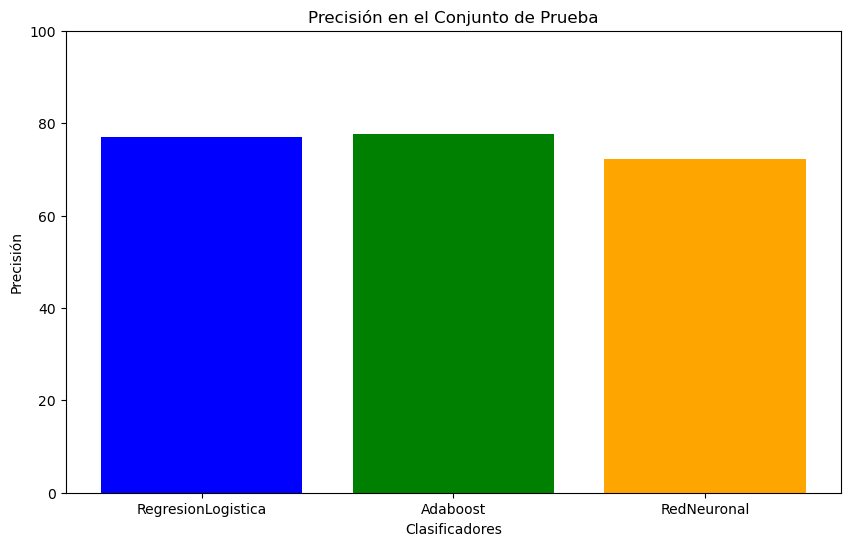

In [88]:
clasificadores = [LogisticRegression(C=best_model_log.C, penalty=best_model_log.penalty, solver=best_model_log.solver, multi_class=best_model_log.multi_class),
                  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=1), n_estimators=best_model_adaboost.n_estimators),
                  MLPClassifier(hidden_layer_sizes = best_model_red.hidden_layer_sizes, max_iter=best_model_red.max_iter, solver=best_model_red.solver)]



nombres = ['RegresionLogistica', 'Adaboost', 'RedNeuronal']
winners = []
best_val = 0

# Inicializar precisiones
precision = []
ganador = (0, 0)
bestPres = 0

for i, clasificador in enumerate(clasificadores):
    # Construir clasificador, entrenarlo, obtener precisiones
    clasificador.fit(X_train, y_train_calificacion)
    accTrain = 100 * clasificador.score(X_train, y_train_calificacion)
    accVal = 100 * clasificador.score(X_val, y_val_calificacion)
    accTest = 100 * clasificador.score(X_test, y_test_calificacion)
    precision.append((nombres[i], accTrain, accVal, accTest))

    if (accVal > bestPres):
        bestPres = accVal
        ganador = (nombres[i], accTest)

# Precisión en el conjunto de prueba
prec_test = [result[2] for result in precision]
# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(nombres, prec_test, color=['blue', 'green', 'orange'])
plt.title('Precisión en el Conjunto de Prueba')
plt.xlabel('Clasificadores')
plt.ylabel('Precisión')
plt.ylim(0, 100)  # Ajusta según tus valores de precisión
plt.show()

# K-Means

Como nuestros ejemplos los hemos etiquetado nosotros, creemos que seria interesante probar un modelo de clustering ya que el dataset original no tiene los datos etiquetados y estudiar los clusters resultantes.

Comprobaremos mediante DB estudiado en clase el mejor numero de clusters.

In [ ]:
# Lee el archivo CSV
df = pd.read_csv('student.csv')

# Selecciona solo las columnas 'G1' y 'G2'
df = df[['G1', 'G2']]

# Divide los datos en conjuntos de entrenamiento y prueba
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Estandariza los datos de entrenamiento
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)

# Estandariza los datos de prueba
test_data_scaled = scaler.transform(test_data)

# Inicializa la lista para guardar los índices de Davies-Bouldin
db_scores = []

# Prueba diferentes valores de k
for k in range(2, 10):
    # Crea el modelo de K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Ajusta el modelo a los datos de entrenamiento
    kmeans.fit(train_data_scaled)

    # Obtiene las etiquetas de los clusters para los datos de entrenamiento
    train_labels = kmeans.labels_

    # Predice las etiquetas de los clusters para los datos de prueba
    test_labels = kmeans.predict(test_data_scaled)

    # Calcula el índice de Davies-Bouldin para los datos de entrenamiento
    db_score = davies_bouldin_score(train_data_scaled, train_labels)
    
    # Guarda el índice de Davies-Bouldin en la lista
    db_scores.append(db_score)

# Encuentra el valor de k que da el índice de Davies-Bouldin más bajo
best_k = db_scores.index(min(db_scores)) + 2

print("El mejor valor de k es: ", best_k)

El mejor valor de k es:  5
